# Thermal Dust map from Planck

# Libraries

In [1]:
# import required libraries
import os
import sys
import glob
import pickle

import copy as cp
import itertools as it

import seaborn as sns
import numpy   as np
import pandas  as pd
import healpy  as hp

from astropy.io import fits
import scipy
import pickle

import matplotlib.pyplot as plt
import matplotlib        as mpl

plt.rcParams["font.family"] = 'STIXGeneral' # 'Arial' # 'Georgia' # "Times New Roman"

from astropy.io.votable import from_table, parse_single_table, parse
from matplotlib.ticker  import AutoMinorLocator    

import h5py as h5

In [2]:
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits

from astropy.wcs import WCS
from spectral_cube import SpectralCube

In [3]:
import astropy.coordinates as coord
import astropy.units as u
from astropy.io import ascii
from astropy.coordinates import SkyCoord
from astropy.wcs import utils

In [4]:
# plt.style.use('ggplot')

# Paths

In [5]:
base  = os.path.expanduser('~')
askap = os.path.join(base, 'ANU', 'ASKAP')
LMC   = os.path.join(askap, 'LMC')

LMC_plots = os.path.join(LMC, 'plots')

gfit_path = os.path.join(LMC, 'gfit')
gfit_result_path = os.path.join(gfit_path, 'results')

data_path = os.path.join(askap, 'data')

data_path = os.path.join(askap, 'data')
LMC_data_path = os.path.join(data_path, 'LMC')
LMC_bridge_data = os.path.join(LMC_data_path, 'bridge')
LMC_GASKAP_data = os.path.join(LMC_data_path, 'lmc_gaskap')
BIGHICAT_data_path = os.path.join(data_path, 'BIGHICAT')

hires_data = os.path.join(LMC_data_path, 'hires')
em_spectra_path = os.path.join(hires_data, 'neighbour_emission_spectra')
hires_results = os.path.join(hires_data, 'results')
hires_em_data = os.path.join(hires_data, 'cube')
hires_em_subcube_data = os.path.join(hires_em_data, 'subcubes')
hires_abs_data = os.path.join(hires_data, 'abs')
hires_em_profile_path = os.path.join(hires_data, 'em_profiles')
abscatv2_data_path = os.path.join(hires_data, 'abscatv2')
abs_dr3_data_path = os.path.join(hires_data, 'absdr3')

GASS_data_path = os.path.join(LMC_data_path, 'GASS')


dust_data_path = os.path.join(data_path, 'dust')
dust_data_path

'/Users/kiemhiep/ANU/ASKAP/data/dust'

In [6]:
# import libs.gfitflex as fitlib
script_dir = os.path.dirname(os.path.realpath('__file__'))
parent_dir = os.path.abspath(os.path.join(script_dir, os.pardir))
print('script_dir: ', script_dir)
print('parent_dir: ', parent_dir)
gaussfit_dir = os.path.join( parent_dir, 'gaussfit')
print('gaussfit_dir: ', gaussfit_dir)
sys.path.append(parent_dir)
module_dir = os.path.join( parent_dir, 'gaussfit', 'modules')
sys.path.append(module_dir)
script_dir

script_dir:  /Users/kiemhiep/opt/anaconda3/envs/gfit/dust
parent_dir:  /Users/kiemhiep/opt/anaconda3/envs/gfit
gaussfit_dir:  /Users/kiemhiep/opt/anaconda3/envs/gfit/gaussfit


'/Users/kiemhiep/opt/anaconda3/envs/gfit/dust'

In [7]:
import gaussfit.modules.decomposer as dc
import gaussfit.modules.fit as find_gcomp
import libs.fitlibs as fitlibs
import config.config as cf

sys.path.append(parent_dir)
from mpfit import mpfit

# Fcn

In [9]:
def read_fits_cube(filename):
    """
    Read 

    Parameters
    ----------
    filename (string) : filename of FITS file
    Input data.

    Returns
    -------
    cube
    WCS
    X-coordinates
    Y-coordinates
    Velocity

    Other parameters
    ----------------
    None
    """
        
    # Read FITS file
    dat = fits.open(filename)  # Open the FITS file for reading
    c = SpectralCube.read(dat)  # Initiate a SpectralCube
    

    # Parse the WCS keywords in the primary HDU
    hdr = dat[0].header
    
    w = WCS(naxis=2)
    w.wcs.crpix = [hdr['CRPIX1'], hdr['CRPIX2']]
    w.wcs.cdelt = np.array([hdr['CDELT1'], hdr['CDELT2']])
    w.wcs.crval = [hdr['CRVAL1'], hdr['CRVAL2']]
    w.wcs.ctype = [hdr['CTYPE1'], hdr['CTYPE2']]


    dat.close() 

    print(f"Cube shape: {c.shape}")

    del dat
    
    _, _, x = c.world[0, 0, :]      # extract RA: deg
    _, y, _ = c.world[0, :, 0]      # extract DEC:  deg
    v, _, _ = c.world[:, 0, 0]      # extract velocity
    
    return c, w, x, y, v, hdr

In [ ]:
# Define customized function
def avg_std(col):
    return np.sqrt(np.sum(col**2))

# Approximate locations of LMC and SMC

In [17]:
# Approximate locations of LMC and SMC
SMC_xcirc, SMC_ycirc = cf.SMC['circ']
LMC_xcirc, LMC_ycirc = cf.LMC['circ']

# Read BIGHICAT

In [18]:
bighicat_file = os.path.join(BIGHICAT_data_path, 'all_unique_LOS_new.csv')
bighicat_df = pd.read_csv(bighicat_file)
bighicat_df = bighicat_df[np.isfinite(bighicat_df.ra.values)]
bighicat_df = bighicat_df[bighicat_df.f_CNM_LOS > 0.]
bighicat_nrows, bighicat_ncols = bighicat_df.shape
print(bighicat_nrows, bighicat_ncols)

199 30


In [19]:
bighicat_df

,source,survey,lon,lat,ra,dec,NHI_LOS,f_CNM_LOS,f_WNM_LOS,NHI_CNM_LOS,...,EBV_2013,AV_2013,ICO10_1,ICO10_2,ICO21,Td,e_Td,qPAH,f_CNM_LOS_KOK14,e_f_CNM_LOS_KOK14
0,J0022,21-SPONGE,107.461730,-61.748239,5.605941,0.248934,2.642248,0.040872,0.627534,0.107994,...,0.032554,0.100917,33.513996,-0.105451,-0.000096,18.925838,0.358167,0.025,0.065020,0.034327
1,3C018A,21-SPONGE,118.623255,-52.731718,10.211263,10.051389,6.287702,0.523649,0.476351,3.292549,...,0.156406,0.484859,-34.840927,1.581829,-0.297675,18.217377,0.794297,0.042,0.581377,0.263721
2,3C018B,21-SPONGE,118.616421,-52.718907,10.206185,10.063889,6.273332,0.525139,0.474861,3.294371,...,0.156406,0.484859,-34.840927,1.581829,-0.297675,18.217377,0.794297,0.042,0.571241,0.258198
3,3C041A,21-SPONGE,131.378783,-29.074651,21.686793,33.217306,5.463896,0.004445,0.630555,0.024289,...,0.075769,0.234883,5.707996,-0.018077,0.084511,19.713444,0.543411,0.050,0.092098,0.045187
4,3C041B,21-SPONGE,131.373859,-29.069848,21.682609,33.222722,5.468773,0.161569,0.838431,0.883582,...,0.075073,0.232728,0.130720,0.259304,0.039420,19.725590,0.554813,0.052,0.095320,0.047690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,J17304,MACH,75.772200,33.067700,262.685109,49.106959,2.500000,0.120000,0.880000,0.300000,...,0.041254,0.127889,-17.716097,-0.306228,-0.234197,17.608982,0.372730,0.057,NaN,NaN
369,J17305,MACH,62.989300,31.515300,262.725150,38.197218,3.340000,0.080000,0.920000,0.267200,...,0.048668,0.150870,-6.611929,-0.689890,0.163849,18.828846,0.375549,0.055,NaN,NaN
370,J17395,MACH,74.222100,31.396300,264.987619,47.632615,2.100000,0.010000,0.990000,0.021000,...,0.024448,0.075789,-4.240314,-0.046202,-1.399806,16.961460,0.294231,0.074,NaN,NaN
371,J17403,MACH,79.563300,31.748300,265.153694,52.195089,2.930000,0.010000,0.990000,0.029300,...,0.049554,0.153618,-17.370651,-0.365892,-1.449508,18.306437,0.388935,0.059,NaN,NaN


In [20]:
bighicat_df.columns

Index(['source', 'survey', 'lon', 'lat', 'ra', 'dec', 'NHI_LOS', 'f_CNM_LOS',
       'f_WNM_LOS', 'NHI_CNM_LOS', 'NHI_WNM_LOS', 'int_Ts', 'e_int_Ts',
       'tau_peak', 'tau_sensitivity', 'ncomps', 'EBV_GNILC', 'e_EBV_GNILC',
       'AV_GNILC', 'e_AV_GNILC', 'EBV_2013', 'AV_2013', 'ICO10_1', 'ICO10_2',
       'ICO21', 'Td', 'e_Td', 'qPAH', 'f_CNM_LOS_KOK14', 'e_f_CNM_LOS_KOK14'],
      dtype='object')

In [21]:
bighicat_fcnm = bighicat_df['f_CNM_LOS']
bighicat_sigfcnm = bighicat_fcnm*0.1
bighicat_av = bighicat_df['AV_2013']

In [22]:
bighicat_gl = bighicat_df.lon.values
bighicat_gb = bighicat_df.lat.values

In [23]:
bighicat_ncomp = bighicat_df.ncomps.values

In [24]:
bighicat_non_abs_df = bighicat_df[bighicat_df.ncomps == 0]
bighicat_non_abs_df

,source,survey,lon,lat,ra,dec,NHI_LOS,f_CNM_LOS,f_WNM_LOS,NHI_CNM_LOS,...,EBV_2013,AV_2013,ICO10_1,ICO10_2,ICO21,Td,e_Td,qPAH,f_CNM_LOS_KOK14,e_f_CNM_LOS_KOK14
347,J16114,MACH,64.5488,46.9059,242.951971,40.672200,0.69,0.05,0.95,0.0345,...,0.013145,0.040749,28.752806,-0.272594,0.230843,16.234470,0.304221,0.058,NaN,NaN
356,J16574,MACH,74.3683,38.4778,254.445018,48.142231,1.44,0.01,0.99,0.0144,...,0.027691,0.085842,0.163636,-1.077122,-1.168932,18.540604,0.225732,0.038,NaN,NaN
359,J17024,MACH,83.3471,37.3166,255.695643,55.277368,1.36,0.02,0.98,0.0272,...,0.025312,0.078468,5.028883,0.072909,0.020911,17.781618,0.258035,0.044,NaN,NaN


In [25]:
bighicat_nabs123_df = bighicat_df[(bighicat_df.ncomps > 0) & (bighicat_df.ncomps < 4)]
bighicat_nabs456_df = bighicat_df[(bighicat_df.ncomps > 3) & (bighicat_df.ncomps < 7)]
bighicat_nabs789_df = bighicat_df[(bighicat_df.ncomps > 6) & (bighicat_df.ncomps < 10)]
bighicat_nabs10_df = bighicat_df[bighicat_df.ncomps > 9]

### BIGHICAT high latitudes

In [27]:
blim = 10.
hghlat_df = bighicat_df[abs(bighicat_df.lat) > blim]
hghlat_df.head()

,source,survey,lon,lat,ra,dec,NHI_LOS,f_CNM_LOS,f_WNM_LOS,NHI_CNM_LOS,...,EBV_2013,AV_2013,ICO10_1,ICO10_2,ICO21,Td,e_Td,qPAH,f_CNM_LOS_KOK14,e_f_CNM_LOS_KOK14
0,J0022,21-SPONGE,107.461730,-61.748239,5.605941,0.248934,2.642248,0.040872,0.627534,0.107994,...,0.032554,0.100917,33.513996,-0.105451,-0.000096,18.925838,0.358167,0.025,0.065020,0.034327
1,3C018A,21-SPONGE,118.623255,-52.731718,10.211263,10.051389,6.287702,0.523649,0.476351,3.292549,...,0.156406,0.484859,-34.840927,1.581829,-0.297675,18.217377,0.794297,0.042,0.581377,0.263721
2,3C018B,21-SPONGE,118.616421,-52.718907,10.206185,10.063889,6.273332,0.525139,0.474861,3.294371,...,0.156406,0.484859,-34.840927,1.581829,-0.297675,18.217377,0.794297,0.042,0.571241,0.258198
3,3C041A,21-SPONGE,131.378783,-29.074651,21.686793,33.217306,5.463896,0.004445,0.630555,0.024289,...,0.075769,0.234883,5.707996,-0.018077,0.084511,19.713444,0.543411,0.050,0.092098,0.045187
4,3C041B,21-SPONGE,131.373859,-29.069848,21.682609,33.222722,5.468773,0.161569,0.838431,0.883582,...,0.075073,0.232728,0.130720,0.259304,0.039420,19.725590,0.554813,0.052,0.095320,0.047690


In [28]:
hghlat_df.columns

Index(['source', 'survey', 'lon', 'lat', 'ra', 'dec', 'NHI_LOS', 'f_CNM_LOS',
       'f_WNM_LOS', 'NHI_CNM_LOS', 'NHI_WNM_LOS', 'int_Ts', 'e_int_Ts',
       'tau_peak', 'tau_sensitivity', 'ncomps', 'EBV_GNILC', 'e_EBV_GNILC',
       'AV_GNILC', 'e_AV_GNILC', 'EBV_2013', 'AV_2013', 'ICO10_1', 'ICO10_2',
       'ICO21', 'Td', 'e_Td', 'qPAH', 'f_CNM_LOS_KOK14', 'e_f_CNM_LOS_KOK14'],
      dtype='object')

In [29]:
bighicat_tau = hghlat_df.tau_peak.values
bighicat_sigtau = hghlat_df.tau_sensitivity.values

In [30]:
bighicat_glon = hghlat_df.lon.values
bighicat_glat = hghlat_df.lat.values

### BIGHICAT components

In [31]:
bighicat_cpn_file = os.path.join(BIGHICAT_data_path, 'all_unique_CNM_det_gaussian_components_new.csv')
bighicat_cpn_df = pd.read_csv(bighicat_cpn_file)
bighicat_cpn_nrows, bighicat_cpn_ncols = bighicat_cpn_df.shape
print(bighicat_cpn_nrows, bighicat_cpn_ncols)

1370 41


In [32]:
bighicat_cpn_df.columns

Index(['source', 'survey', 'lon', 'lat', 'tau', 'e_tau', 'fwhm_abs',
       'e_fwhm_abs', 'v_abs', 'e_v_abs', 'Tb', 'e_Tb', 'fwhm_em', 'e_fwhm_em',
       'v_em', 'e_v_em', 'NHI', 'e_NHI', 'Ts', 'e_Ts', 'ncomps', 'NHI_LOS',
       'f_CNM_LOS', 'f_CNM_LOS_KOK14', 'e_f_CNM_LOS_KOK14', 'f_WNM_LOS',
       'NHI_CNM_LOS', 'NHI_WNM_LOS', 'int_Ts', 'EBV_GNILC', 'e_EBV_GNILC',
       'AV_GNILC', 'e_AV_GNILC', 'EBV_2013', 'AV_2013', 'ICO10_1', 'ICO10_2',
       'ICO21', 'Td', 'e_Td', 'qPAH'],
      dtype='object')

In [33]:
blim = 10.
hghlat_cpn_df = bighicat_cpn_df[(abs(bighicat_cpn_df.lat) > blim) & (bighicat_cpn_df.Ts.values < 1200.) & (bighicat_cpn_df.Ts.values > 0.)]
print(hghlat_cpn_df.shape)
hghlat_cpn_df.head()

(612, 41)


,source,survey,lon,lat,tau,e_tau,fwhm_abs,e_fwhm_abs,v_abs,e_v_abs,...,AV_GNILC,e_AV_GNILC,EBV_2013,AV_2013,ICO10_1,ICO10_2,ICO21,Td,e_Td,qPAH
0,1055+018,21-SPONGE,-108.489395,52.773983,0.006418,0.000211,7.061405,0.2533794334354352,-7.276518,0.1093717782616211,...,0.079088,0.001155,0.036975,0.114623,16.987488,5.668997,-10.984881,19.149420,0.188328,0.046
1,3C018A,21-SPONGE,118.623255,-52.731718,0.565354,0.006562,2.459576,0.019208588234467958,-9.141851,0.004865720945763916,...,0.499145,0.031410,0.156406,0.484859,-34.840927,1.581829,-0.297675,18.217377,0.794297,0.042
2,3C018A,21-SPONGE,118.623255,-52.731718,0.134434,0.002977,5.489022,0.16556715332829863,-6.190596,0.11759097439950161,...,0.499145,0.031410,0.156406,0.484859,-34.840927,1.581829,-0.297675,18.217377,0.794297,0.042
5,3C018B,21-SPONGE,118.616421,-52.718907,0.524365,0.003100,2.407914,0.014013971447450221,-8.976387,0.004214825863018799,...,0.499145,0.031410,0.156406,0.484859,-34.840927,1.581829,-0.297675,18.217377,0.794297,0.042
6,3C018B,21-SPONGE,118.616421,-52.718907,0.148800,0.002044,6.160155,0.05849457348843577,-6.774723,0.0487960503841556,...,0.499145,0.031410,0.156406,0.484859,-34.840927,1.581829,-0.297675,18.217377,0.794297,0.042


In [34]:
bighicat_taucnm = hghlat_cpn_df.tau.values
bighicat_sigtaucnm = hghlat_cpn_df.e_tau.values

bighicat_tscnm = hghlat_cpn_df.Ts.values
bighicat_sigtscnm = hghlat_cpn_df.e_Ts.values

bighicat_cpn_glon = hghlat_cpn_df.lon.values
bighicat_cpn_glat = hghlat_cpn_df.lat.values

In [35]:
hghlat_cpn_df[['source', 'survey', 'lon', 'lat', 'tau', 'e_tau', 'fwhm_abs',
       'e_fwhm_abs', 'v_abs', 'e_v_abs', 'Tb', 'e_Tb', 'fwhm_em', 'e_fwhm_em',
       'v_em', 'e_v_em', 'NHI', 'e_NHI', 'Ts', 'e_Ts', 'ncomps', 'NHI_LOS',
       'f_CNM_LOS']]

,source,survey,lon,lat,tau,e_tau,fwhm_abs,e_fwhm_abs,v_abs,e_v_abs,...,e_fwhm_em,v_em,e_v_em,NHI,e_NHI,Ts,e_Ts,ncomps,NHI_LOS,f_CNM_LOS
0,1055+018,21-SPONGE,-108.489395,52.773983,0.006418,0.000211,7.061405,0.2533794334354352,-7.276518,0.1093717782616211,...,0.000000,-6.843069,0.000000,0.827511,0.048499,941.344712,30.798667,1.0,2.943138,0.000000
1,3C018A,21-SPONGE,118.623255,-52.731718,0.565354,0.006562,2.459576,0.019208588234467958,-9.141851,0.004865720945763916,...,0.000000,-10.272452,0.000000,0.481065,0.040496,17.835869,1.480552,4.0,6.287702,0.523649
2,3C018A,21-SPONGE,118.623255,-52.731718,0.134434,0.002977,5.489022,0.16556715332829863,-6.190596,0.11759097439950161,...,0.000000,-5.477219,0.000000,2.811484,0.130961,196.428242,5.449175,4.0,6.287702,0.523649
5,3C018B,21-SPONGE,118.616421,-52.718907,0.524365,0.003100,2.407914,0.014013971447450221,-8.976387,0.004214825863018799,...,0.265945,-10.264445,0.346109,0.407920,0.060957,16.656050,2.485132,2.0,6.273332,0.525139
6,3C018B,21-SPONGE,118.616421,-52.718907,0.148800,0.002044,6.160155,0.05849457348843577,-6.774723,0.0487960503841556,...,0.040578,-6.669918,0.021774,2.886451,0.099639,162.345752,4.904859,2.0,6.273332,0.525139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1365,J17305,MACH,62.989309,31.515281,0.265273,0.004244,1.766504,0.032188036802595556,-1.721723,0.013781610396698542,...,0.097596,-0.549130,0.503466,0.371817,0.021779,35.272140,1.061401,1.0,3.340000,0.080000
1366,J17395,MACH,74.222149,31.396336,0.093102,0.001962,1.915317,0.04561607903694073,0.509023,0.01957865050933494,...,0.100540,0.162645,0.951671,0.660107,0.037285,163.375894,4.405454,1.0,2.100000,0.010000
1367,J17403,MACH,79.563304,31.748315,0.160304,0.002752,1.888898,0.06312492069606991,-1.029581,0.02805279460356263,...,0.028011,-1.366541,0.363143,0.164376,0.010449,27.985547,1.661898,2.0,2.930000,0.010000
1368,J17403,MACH,79.563304,31.748315,0.108895,0.003599,1.358413,0.0668096394427551,0.910594,0.03310903642575238,...,0.000062,0.774825,0.327112,0.134972,0.008130,38.876964,1.957794,2.0,2.930000,0.010000


In [36]:
bighicat_cpn_glon[bighicat_cpn_glon < 0.] = bighicat_cpn_glon[bighicat_cpn_glon < 0.] + 360.

In [37]:
hghlat_cpn_df.columns

Index(['source', 'survey', 'lon', 'lat', 'tau', 'e_tau', 'fwhm_abs',
       'e_fwhm_abs', 'v_abs', 'e_v_abs', 'Tb', 'e_Tb', 'fwhm_em', 'e_fwhm_em',
       'v_em', 'e_v_em', 'NHI', 'e_NHI', 'Ts', 'e_Ts', 'ncomps', 'NHI_LOS',
       'f_CNM_LOS', 'f_CNM_LOS_KOK14', 'e_f_CNM_LOS_KOK14', 'f_WNM_LOS',
       'NHI_CNM_LOS', 'NHI_WNM_LOS', 'int_Ts', 'EBV_GNILC', 'e_EBV_GNILC',
       'AV_GNILC', 'e_AV_GNILC', 'EBV_2013', 'AV_2013', 'ICO10_1', 'ICO10_2',
       'ICO21', 'Td', 'e_Td', 'qPAH'],
      dtype='object')

In [38]:
hghlat_cpn_df.Ts

0       941.344712
1        17.835869
2       196.428242
5        16.656050
6       162.345752
           ...    
1365     35.272140
1366    163.375894
1367     27.985547
1368     38.876964
1369    104.572570
Name: Ts, Length: 612, dtype: float64

In [39]:
hghlat_cpn_df.e_Ts

0       30.798667
1        1.480552
2        5.449175
5        2.485132
6        4.904859
          ...    
1365     1.061401
1366     4.405454
1367     1.661898
1368     1.957794
1369     7.306931
Name: e_Ts, Length: 612, dtype: float64

# Ts_mean: BIGHICAT

In [42]:
# Define a function to calculate weighted mean and uncertainty
def weighted_mean_with_uncertainty(df_group):
    weighted_mean = np.average(df_group['Ts'], weights=df_group['NHI'])
    weighted_variance = np.average((df_group['Ts'] - weighted_mean) ** 2, weights=df_group['NHI'])
    weighted_uncertainty = np.sqrt(weighted_variance + np.average(df_group['e_Ts'] ** 2, weights=df_group['NHI']))
    return pd.Series([weighted_mean, weighted_uncertainty], index=['weighted_mean', 'weighted_uncertainty'])

# Group by column 'c' and calculate the weighted mean for each group
grouped_df = hghlat_cpn_df.groupby('source').apply(weighted_mean_with_uncertainty)

grouped_df = grouped_df.reset_index().sort_values('source')
bighi_tspin_mean = grouped_df['weighted_mean'].values
bighi_sigtspin_mean = grouped_df['weighted_uncertainty'].values

grouped_df

,source,weighted_mean,weighted_uncertainty
0,1055+018,941.344712,30.798667
1,3C018A,170.334629,63.284429
2,3C018B,144.305968,48.214318
3,3C041A,348.775828,28.589475
4,3C041B,148.891413,15.546528
...,...,...,...
209,P1117+14,208.343949,NaN
210,PKS0742,164.076921,9.844056
211,PKS1607,102.050893,33.063119
212,PKS2127,567.259758,313.862817


In [43]:
bighi_src_gl = []
bighi_src_gb = []
bighi_nhi_src = []
for srci in grouped_df['source'].values:
    bighi_src_gl.append(bighicat_cpn_df[bighicat_cpn_df['source'] == srci]['lon'].iloc[0])
    bighi_src_gb.append(bighicat_cpn_df[bighicat_cpn_df['source'] == srci]['lat'].iloc[0])
    bighi_nhi_src.append(bighicat_cpn_df[bighicat_cpn_df['source'] == srci]['NHI_LOS'].iloc[0])

bighi_src_gl = np.array(bighi_src_gl)
bighi_src_gb = np.array(bighi_src_gb)
bighi_nhi_src = np.array(bighi_nhi_src)
len(bighi_nhi_src)

214

In [44]:
bighicat_cpn_df[['source', 'survey', 'lon', 'lat', 'tau', 'e_tau', 'fwhm_abs',
       'e_fwhm_abs', 'v_abs', 'e_v_abs', 'Tb', 'e_Tb', 'fwhm_em', 'e_fwhm_em',
       'v_em', 'e_v_em', 'NHI', 'e_NHI', 'Ts', 'e_Ts', 'ncomps', 'NHI_LOS',
       'f_CNM_LOS']]

,source,survey,lon,lat,tau,e_tau,fwhm_abs,e_fwhm_abs,v_abs,e_v_abs,...,e_fwhm_em,v_em,e_v_em,NHI,e_NHI,Ts,e_Ts,ncomps,NHI_LOS,f_CNM_LOS
0,1055+018,21-SPONGE,-108.489395,52.773983,0.006418,0.000211,7.061405,0.2533794334354352,-7.276518,0.1093717782616211,...,0.000000,-6.843069,0.000000,0.827511,0.048499,941.344712,30.798667,1.0,2.943138,0.000000
1,3C018A,21-SPONGE,118.623255,-52.731718,0.565354,0.006562,2.459576,0.019208588234467958,-9.141851,0.004865720945763916,...,0.000000,-10.272452,0.000000,0.481065,0.040496,17.835869,1.480552,4.0,6.287702,0.523649
2,3C018A,21-SPONGE,118.623255,-52.731718,0.134434,0.002977,5.489022,0.16556715332829863,-6.190596,0.11759097439950161,...,0.000000,-5.477219,0.000000,2.811484,0.130961,196.428242,5.449175,4.0,6.287702,0.523649
3,3C018A,21-SPONGE,118.623255,-52.731718,0.084064,0.003265,1.491306,0.06251029338893384,-4.954399,0.020768842391248377,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,6.287702,0.523649
4,3C018A,21-SPONGE,118.623255,-52.731718,0.007436,0.002707,0.745783,0.31345678134704164,24.367670,0.13311283917109765,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,6.287702,0.523649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1365,J17305,MACH,62.989309,31.515281,0.265273,0.004244,1.766504,0.032188036802595556,-1.721723,0.013781610396698542,...,0.097596,-0.549130,0.503466,0.371817,0.021779,35.272140,1.061401,1.0,3.340000,0.080000
1366,J17395,MACH,74.222149,31.396336,0.093102,0.001962,1.915317,0.04561607903694073,0.509023,0.01957865050933494,...,0.100540,0.162645,0.951671,0.660107,0.037285,163.375894,4.405454,1.0,2.100000,0.010000
1367,J17403,MACH,79.563304,31.748315,0.160304,0.002752,1.888898,0.06312492069606991,-1.029581,0.02805279460356263,...,0.028011,-1.366541,0.363143,0.164376,0.010449,27.985547,1.661898,2.0,2.930000,0.010000
1368,J17403,MACH,79.563304,31.748315,0.108895,0.003599,1.358413,0.0668096394427551,0.910594,0.03310903642575238,...,0.000062,0.774825,0.327112,0.134972,0.008130,38.876964,1.957794,2.0,2.930000,0.010000


In [45]:
bighicat_cpn_df[bighicat_cpn_df['source'] == srci].columns

Index(['source', 'survey', 'lon', 'lat', 'tau', 'e_tau', 'fwhm_abs',
       'e_fwhm_abs', 'v_abs', 'e_v_abs', 'Tb', 'e_Tb', 'fwhm_em', 'e_fwhm_em',
       'v_em', 'e_v_em', 'NHI', 'e_NHI', 'Ts', 'e_Ts', 'ncomps', 'NHI_LOS',
       'f_CNM_LOS', 'f_CNM_LOS_KOK14', 'e_f_CNM_LOS_KOK14', 'f_WNM_LOS',
       'NHI_CNM_LOS', 'NHI_WNM_LOS', 'int_Ts', 'EBV_GNILC', 'e_EBV_GNILC',
       'AV_GNILC', 'e_AV_GNILC', 'EBV_2013', 'AV_2013', 'ICO10_1', 'ICO10_2',
       'ICO21', 'Td', 'e_Td', 'qPAH'],
      dtype='object')

# Read MC catalogue DR3

All MC sightlines

In [56]:
MC_fg_cat_file = os.path.join(abs_dr3_data_path, 'gaskap_abs_spectra_dr3b.csv')
df = pd.read_csv(MC_fg_cat_file)

nrows, ncols = df.shape
print('Number of rows: %i, columns %i. ' %(nrows, ncols))
df.head(5)

Number of rows: 2714, columns 33. 


,id,comp_name,component_id,ra,dec,glon,glat,rating,flux_peak,flux_int,...,semi_min_axis,pa,n_h,noise_flag,continuum_slope,field,all_sbids,sbid,mw_detection,saturated
0,0,J005611-710706,SB30665_component_1a,14.047482,-71.118446,302.378462,-46.004698,A,519.130005,442.507996,...,4.215,33.869999,1.236612e+21,False,0.000923,M344-11,30665,30665,True,False
1,8,J011049-731427,SB30665_component_3a,17.707468,-73.240921,300.996592,-43.814386,A,457.480988,596.744995,...,5.350,54.860001,4.874624e+21,False,-0.000770,M344-11,30665,30665,True,False
2,9,J011056-731406,SB30665_component_3b,17.735945,-73.235151,300.984436,-43.819266,A,115.037003,208.171005,...,5.745,39.880001,4.874624e+21,False,-0.000363,M344-11,30665,30665,False,False
3,10,J004048-714600,SB30665_component_4a,10.200474,-71.766489,304.115161,-45.337319,A,428.450012,463.325989,...,4.905,175.600006,4.498524e+20,False,0.000679,M344-11,30665,30665,True,False
4,11,J005732-741242,SB30665_component_5a,14.385728,-74.211897,302.365011,-42.909634,A,428.031006,461.653015,...,4.895,175.509995,5.650006e+20,False,0.000971,M344-11,30665,30665,True,False


# Results DR3: Integrated properties

In [72]:
MC_fg_gfit_res_file = os.path.join(hires_results, 'hires_result_table_dr3.csv') # DR3
mc_fg_res_df = pd.read_csv(MC_fg_gfit_res_file)
mc_fg_res_df = mc_fg_res_df.sort_values('comp_name')

nrows, ncols = mc_fg_res_df.shape
print('Number of rows: %i, columns %i. ' %(nrows, ncols))
mc_fg_res_df.head(5)

Number of rows: 462, columns 42. 


,comp_name,sbid,uniq_name,ra,dec,glon,glat,in_bridge,rating,flux_peak,...,fcnm,sigfcnm,Rfactor,sigRfactor,nhi,signhi,nhi_thin,signhi_thin,ncnm,tsky
5,J001424-733911,30665,J001424-733911-30665,3.601159,-73.653109,306.494335,-43.218047,0,A,184.315994,...,0.355924,0.063481,1.032038,0.123268,2.730491,0.297817,2.646857,0.110566,2,3.555342
14,J002144-741500,30665,J002144-741500-30665,5.433208,-74.249829,305.669096,-42.720187,0,B,122.134003,...,0.256970,0.051081,1.003609,0.139190,3.164146,0.399856,3.152547,0.179060,2,3.561425
15,J002223-742825,30665,J002223-742825-30665,5.597676,-74.473760,305.562542,-42.505801,0,B,103.077003,...,0.300266,0.038231,1.029805,0.093871,2.909353,0.249468,2.823752,0.085782,2,3.561425
21,J002248-734007,30665,J002248-734007-30665,5.700254,-73.668709,305.692177,-43.305728,0,B,49.626999,...,0.342519,0.043122,1.059104,0.084394,3.155461,0.213848,2.971679,0.125477,1,3.564467
13,J002335-735529,30665,J002335-735529-30665,5.895892,-73.924770,305.565463,-43.060758,0,B,62.061001,...,0.160020,0.032376,0.933793,0.093914,2.635446,0.234640,2.824470,0.128897,1,3.567508


In [73]:
sources = mc_fg_res_df['comp_name'].values
nabs_sources = len(sources)
nabs_sources

462

In [74]:
uniq_sources = mc_fg_res_df['comp_name'].unique()
nabs_uniq_sources = len(uniq_sources)
nabs_uniq_sources

462

In [75]:
assert nabs_sources == nabs_uniq_sources

In [76]:
mc_src_gl = mc_fg_res_df['glon'].values
mc_src_gb = mc_fg_res_df['glat'].values

fields = mc_fg_res_df['sbid'].unique()
nfields = len(fields)
nfields

10

In [78]:
src_fields = mc_fg_res_df['sbid'].values
len(src_fields)

462

In [79]:
# Lines-of-sight towards the SMC foreground
smc_src_gl = mc_fg_res_df[mc_fg_res_df['sbid'] == 0]['glon']
smc_src_gb = mc_fg_res_df[mc_fg_res_df['sbid'] == 0]['glat']
n_smc_fg_srcs = len(smc_src_gb)

In [80]:
n_lmc_fg_srcs = nabs_sources - n_smc_fg_srcs
print(n_smc_fg_srcs)
print(n_lmc_fg_srcs)

0
462


# Result Gfit: components

In [83]:
MC_fg_gfit_res_file = os.path.join(gfit_path, 'MC_GD_result_CNM_components.csv')
MC_fg_gfit_res_file = os.path.join(hires_results, 'hires_result_CNM_components_dr3.csv') # DR3
MC_fg_gfit_res_file

'/Users/kiemhiep/ANU/ASKAP/data/LMC/hires/results/hires_result_CNM_components_dr3.csv'

In [84]:
mc_fg_cpn_df = pd.read_csv(MC_fg_gfit_res_file)
mc_fg_cpn_df.shape

(691, 39)

In [88]:
# Group by 'Group' and calculate the mean of 'Value1' and the sum of 'Value2'
result = mc_fg_cpn_df.groupby('comp_name').agg({'tscnm': 'mean', 'sigtscnm': avg_std})
result = result.reset_index().sort_values('comp_name')
tspin_mean = result['tscnm'].values
sigtspin_mean = result['sigtscnm'].values

result

,comp_name,tscnm,sigtscnm
0,J001424-733911,65.796504,20.377934
1,J002144-741500,49.595013,24.222079
2,J002223-742825,80.899866,13.880308
3,J002248-734007,52.051044,6.355195
4,J002335-735529,53.248983,13.350175
...,...,...,...
457,J061014-743208,48.052885,2.317335
458,J061014-743214,46.280037,2.128937
459,J061024-711917,81.266014,38.546841
460,J061030-700235,46.344885,10.392683


In [89]:
# Important to check here
assert np.all(result['comp_name'].values == sources)
np.all(result['comp_name'].values == sources)

True

In [90]:
assert np.all(result['comp_name'].values ==  mc_fg_res_df['comp_name'].values)

In [91]:
mc_src_gl = mc_fg_res_df['glon'].values
mc_src_gb = mc_fg_res_df['glat'].values
nhi_4_tsmean = mc_fg_res_df['nhi'].values
signhi_4_tsmean = mc_fg_res_df['signhi'].values

In [92]:
tmp_src_gl = []
for srci in result['comp_name'].values:
    # print()
    tmp_src_gl.append(mc_fg_res_df[mc_fg_res_df['comp_name'] == srci]['glon'].squeeze())

In [93]:
np.all(np.array(tmp_src_gl) == mc_src_gl)

True

In [96]:
# Define a function to calculate weighted mean and uncertainty
def weighted_mean_with_uncertainty(df_group):
    weighted_mean = np.average(df_group['tscnm'], weights=df_group['nhicnm_cpn'])
    weighted_variance = np.average((df_group['tscnm'] - weighted_mean) ** 2, weights=df_group['nhicnm_cpn'])
    weighted_uncertainty = np.sqrt(weighted_variance + np.average(df_group['sigtscnm'] ** 2, weights=df_group['nhicnm_cpn']))
    return pd.Series([weighted_mean, weighted_uncertainty], index=['weighted_mean', 'weighted_uncertainty'])

# Group by column 'c' and calculate the weighted mean for each group
grouped_df = mc_fg_cpn_df.groupby('comp_name').apply(weighted_mean_with_uncertainty)

grouped_df = grouped_df.reset_index().sort_values('comp_name')
tspin_mean = grouped_df['weighted_mean'].values
sigtspin_mean = grouped_df['weighted_uncertainty'].values

grouped_df

,comp_name,weighted_mean,weighted_uncertainty
0,J001424-733911,86.646609,20.794031
1,J002144-741500,52.747976,15.678871
2,J002223-742825,85.732474,24.940067
3,J002248-734007,52.051044,6.355195
4,J002335-735529,53.248983,13.350175
...,...,...,...
457,J061014-743208,48.052885,2.317335
458,J061014-743214,46.280037,2.128937
459,J061024-711917,81.266014,38.546841
460,J061030-700235,46.344885,10.392683


In [97]:
tmp_src_gl = []
tmp_src_gb = []
for srci in grouped_df['comp_name'].values:
    tmp_src_gl.append(mc_fg_res_df[mc_fg_res_df['comp_name'] == srci]['glon'].squeeze())
    tmp_src_gb.append(mc_fg_res_df[mc_fg_res_df['comp_name'] == srci]['glat'].squeeze())

In [98]:
np.all(np.array(tmp_src_gb) == mc_src_gb)

True

In [99]:
mc_fg_res_df[mc_fg_res_df['comp_name'] == srci]

,comp_name,sbid,uniq_name,ra,dec,glon,glat,in_bridge,rating,flux_peak,...,fcnm,sigfcnm,Rfactor,sigRfactor,nhi,signhi,nhi_thin,signhi_thin,ncnm,tsky
265,J061328-741046,38845,J061328-741046-38845,93.367202,-74.179643,285.097675,-28.602162,0,A,63.458,...,0.285763,0.016581,1.094157,0.038671,7.787964,0.226642,7.122283,0.146195,1,3.284644


In [100]:
np.all(np.array(tmp_src_gl) == mc_src_gl)

True

# Read dust data

Thermal dust from Planck

In [114]:
planck_data_path = os.path.join(dust_data_path, 'planck')
filename = os.path.join(planck_data_path, "HFI_CompMap_ThermalDustModel_2048_R1.20.fits")

tau353_map = hp.read_map(filename, field=0)
sigtau353_map = hp.read_map(filename, field=1)
nside  = hp.get_nside(tau353_map)
res    = hp.nside2resol(nside, arcmin=False)
res_arcmin = hp.nside2resol(nside, arcmin=True)
print(f"Resolution: {res} (radians), {res_arcmin} (arcmin)")

Resolution: 0.0004996712441144963 (radians), 1.717743205908703 (arcmin)


In [115]:
# src   = info['src'][i]
deg2rad = np.pi/180.
theta = (90. - mc_src_gb)*deg2rad
phi   = mc_src_gl*deg2rad
pix   = hp.ang2pix(nside, theta, phi, nest=False)

tau353    = tau353_map[pix]
sigtau353 = sigtau353_map[pix]
print(len(tau353))
tau353[:5]

462


array([2.1125657e-06, 2.9561409e-06, 3.1613167e-06, 2.8691716e-06,
       2.8961279e-06], dtype=float32)

In [116]:
filename = os.path.join(planck_data_path, "HFI_CompMap_ThermalDustModel_2048_R1.20.fits")

ebv_map = hp.read_map(filename, field=2)
nside  = hp.get_nside(ebv_map)
res    = hp.nside2resol(nside, arcmin=False)
res_arcmin = hp.nside2resol(nside, arcmin=True)
print(f"Resolution: {res} (radians), {res_arcmin} (arcmin)")

Resolution: 0.0004996712441144963 (radians), 1.717743205908703 (arcmin)


In [119]:
nside  = hp.get_nside(ebv_map)
res    = hp.nside2resol(nside, arcmin=False)
res_arcmin = hp.nside2resol(nside, arcmin=True)
print(f"Resolution: {res} (radians), {res_arcmin} (arcmin)")

Resolution: 0.0004996712441144963 (radians), 1.717743205908703 (arcmin)


In [121]:
# From Planck thermal dust paper:
# E(B-V) = (1.49 +/- 0.03)1.e4 * tau353
afactor = 1.49e4
sigafactor = 0.03e4
ebv = ebv_map[pix]
sigebv = np.sqrt(tau353**2*sigafactor**2 + afactor**2*sigtau353**2)

In [122]:
Av    = 3.1*ebv
sigAv = 3.1*sigebv
print(len(Av))
Av[:5]

462


array([0.12114969, 0.14053993, 0.13866389, 0.12901352, 0.1411581 ],
      dtype=float32)

In [123]:
# src   = info['src'][i]
deg2rad = np.pi/180.
theta = (90. - mc_src_gb)*deg2rad
phi   = mc_src_gl*deg2rad
pix   = hp.ang2pix(nside, theta, phi, nest=False)
len(pix)

462

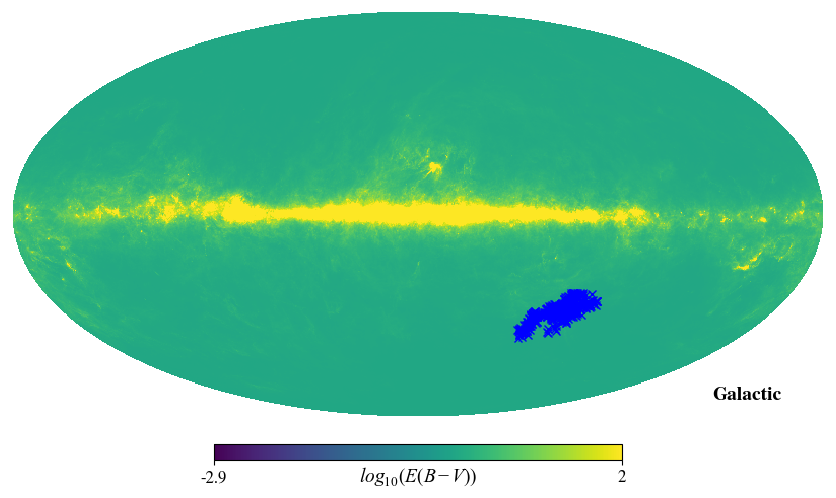

In [126]:
#====== For Plotting ======#
lmc_glon = [270., 307.]
lmc_glat = [-48., -25.]
glon_cen = (lmc_glon[0]+lmc_glon[1])/2.
glat_cen = (lmc_glat[0]+lmc_glat[1])/2.

title = r''
hp.mollview(ebv_map, title='', coord='G', unit=r'$log_{10}(E(B-V))$', norm=None, min=-2.9,max=2.)

hp.projplot(mc_src_gl, mc_src_gb, 'bx', lonlat=True, coord='G')

mpl.rcParams.update({'font.size':12})
plt.grid()
plt.show()

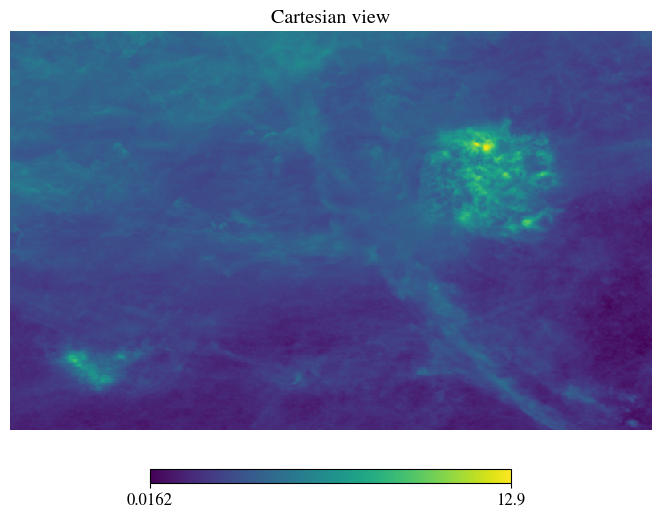

In [127]:
test = hp.cartview(ebv_map, return_projected_map=True, lonra=lmc_glon, latra=lmc_glat, norm='log')
plt.show()

## $F_{CNM}$, $N_{HI}$ and coordinates

In [129]:
mc_fg_res_df.columns

Index(['comp_name', 'sbid', 'uniq_name', 'ra', 'dec', 'glon', 'glat',
       'in_bridge', 'rating', 'flux_peak', 'mean_cont', 'sd_cont',
       'opacity_range', 'max_s_max_n', 'max_noise', 'num_chan_noise',
       'semi_maj_axis', 'semi_min_axis', 'pa', 'min_opacity',
       'vel_min_opacity', 'peak_tau', 'e_peak_tau', 'n_h', 'ew', 'sigew',
       'ewfit', 'sigewfit', 'nhicnm', 'signhicnm', 'nhiwnm', 'signhiwnm',
       'fcnm', 'sigfcnm', 'Rfactor', 'sigRfactor', 'nhi', 'signhi', 'nhi_thin',
       'signhi_thin', 'ncnm', 'tsky'],
      dtype='object')

In [130]:
fcnm = mc_fg_res_df['fcnm'].values
sigfcnm = mc_fg_res_df['sigfcnm'].values
fcnm.shape

(462,)

In [131]:
nhi = mc_fg_res_df['nhi'].values
signhi = mc_fg_res_df['signhi'].values
nhi.shape

(462,)

# CNM Components

In [132]:
mc_fg_cpn_df.columns

Index(['comp_name', 'sbid', 'uniq_name', 'ra', 'dec', 'glon', 'glat',
       'in_bridge', 'rating', 'flux_peak', 'mean_cont', 'sd_cont',
       'opacity_range', 'max_s_max_n', 'max_noise', 'num_chan_noise',
       'semi_maj_axis', 'semi_min_axis', 'pa', 'taucnm', 'sigtaucnm',
       'sigtaunoise', 'cencnm', 'sigcencnm', 'widcnm', 'sigwidcnm', 'tscnm',
       'sigtscnm', 'tbcnm', 'sigtbcnm', 'nhicnm_cpn', 'signhicnm_cpn',
       'fcnm_cpn', 'sigfcnm_cpn', 'nhi_tot', 'signhi_tot', 'tsky',
       'nhicnm_avg', 'signhicnm_avg'],
      dtype='object')

In [133]:
LMC_center_gl = cf.LMC['gl'] # deg
LMC_center_gb = cf.LMC['gb'] # deg

In [134]:
SMC_center_gl = cf.SMC['gl'] # deg
SMC_center_gb = cf.SMC['gb'] # deg
print(SMC_center_gl, SMC_center_gb)

302.0 -44.5


# Tspin: CNM components

In [136]:
mc_fg_cpn_df

,comp_name,sbid,uniq_name,ra,dec,glon,glat,in_bridge,rating,flux_peak,...,sigtbcnm,nhicnm_cpn,signhicnm_cpn,fcnm_cpn,sigfcnm_cpn,nhi_tot,signhi_tot,tsky,nhicnm_avg,signhicnm_avg
0,J005611-710706,30665,J005611-710706-30665,14.047482,-71.118446,302.378462,-46.004698,0,A,519.130005,...,0.492912,0.258148,0.017671,0.115614,0.009510,2.232849,0.101853,3.543176,0.246904,0.023536
1,J011049-731427,30665,J011049-731427-30665,17.707468,-73.240921,300.996592,-43.814386,0,A,457.480988,...,1.093266,0.528091,0.061311,0.191089,0.029765,2.763580,0.286976,3.573591,0.526199,0.077868
2,J011049-731427,30665,J011049-731427-30665,17.707468,-73.240921,300.996592,-43.814386,0,A,457.480988,...,1.093266,0.145281,0.054101,0.052570,0.020323,2.763580,0.286976,3.573591,0.144746,0.066422
3,J004048-714600,30665,J004048-714600-30665,10.200474,-71.766489,304.115161,-45.337319,0,A,428.450012,...,0.809774,1.038635,0.153567,0.348299,0.109031,2.982020,0.822799,3.564467,1.031687,0.194750
4,J005732-741242,30665,J005732-741242-30665,14.385728,-74.211897,302.365011,-42.909634,0,A,428.031006,...,0.643373,0.359050,0.038501,0.131218,0.015583,2.736283,0.139665,3.485386,0.356473,0.053406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
686,J014454-801334,38215,J014454-801334-38215,26.225640,-80.226328,300.129741,-36.609263,1,B,20.705000,...,0.453207,1.416348,0.171045,0.225989,0.028857,6.267342,0.260013,3.515802,1.600893,0.555026
687,J012808-751251,38215,J012808-751251-38215,22.036673,-75.214201,299.807394,-41.690592,1,B,148.449997,...,0.790409,0.572984,0.057847,0.134791,0.073315,4.250919,2.271969,3.430639,0.597434,0.089552
688,J010238-762315,38215,J010238-762315-38215,15.659985,-76.387702,302.062577,-40.721635,1,A,62.705002,...,0.503125,1.140123,0.059094,0.253422,0.017857,4.498908,0.214756,3.409348,1.106552,0.120073
689,J010238-762315,38215,J010238-762315-38215,15.659985,-76.387702,302.062577,-40.721635,1,A,62.705002,...,0.503125,0.687252,0.052560,0.152760,0.013772,4.498908,0.214756,3.409348,0.666387,0.117329


In [137]:
mc_src_gl_cpn = mc_fg_cpn_df['glon'].values
mc_src_gb_cpn = mc_fg_cpn_df['glat'].values
len(mc_src_gb_cpn)

691

In [138]:
ts = mc_fg_cpn_df['tscnm'].values
sigts = mc_fg_cpn_df['sigtscnm'].values
ts.shape

(691,)

In [140]:
theta = (90. - mc_src_gb_cpn)*deg2rad
phi   = mc_src_gl_cpn*deg2rad
pix   = hp.ang2pix(nside, theta, phi, nest=False)

tau353_cpn = tau353_map[pix]
sigtau353_cpn = sigtau353_map[pix]

ebv_cpn = ebv_map[pix]
sigebv_cpn = np.sqrt(tau353_cpn**2*sigafactor**2 + afactor**2*sigtau353_cpn**2)
Av_cpn    = 3.1*ebv_cpn
sigAv_cpn = 3.1*sigebv_cpn
print(len(Av_cpn))
Av_cpn[:5]

691


array([0.14746952, 0.5524542 , 0.5524542 , 0.15837382, 0.17087734],
      dtype=float32)

In [151]:
d_from_LMC_cpn = np.sqrt((mc_src_gl_cpn-LMC_center_gl)**2 + (mc_src_gb_cpn-LMC_center_gb)**2)
d_from_SMC_cpn = np.sqrt((mc_src_gl_cpn-SMC_center_gl)**2 + (mc_src_gb_cpn-SMC_center_gb)**2)

id_cpn_far = np.where( (d_from_LMC_cpn > 6.) & (d_from_SMC_cpn > 4.))[0]
glon_cpn_far = mc_src_gl_cpn[id_cpn_far]
glat_cpn_far = mc_src_gb_cpn[id_cpn_far]

ts_cpn_far = ts[id_cpn_far]
sigts_cpn_far = sigts[id_cpn_far]

443

### For Tsmean along linesights

In [155]:
theta = (90. - bighicat_gb)*deg2rad
phi   = bighicat_gl*deg2rad
pix   = hp.ang2pix(nside, theta, phi, nest=False)

199


array([0.0319775 , 0.02555122, 0.02555122, 0.03227658, 0.03675548],
      dtype=float32)

In [156]:
theta = (90. - bighi_src_gb)*deg2rad
phi   = bighi_src_gl*deg2rad
pix   = hp.ang2pix(nside, theta, phi, nest=False)

214


array([0.03121171, 0.02555122, 0.02555122, 0.03227658, 0.03675548],
      dtype=float32)

In [157]:
d_from_LMC = np.sqrt((bighi_src_gl-LMC_center_gl)**2 + (bighi_src_gb-LMC_center_gb)**2)
d_from_SMC = np.sqrt((bighi_src_gl-SMC_center_gl)**2 + (bighi_src_gb-SMC_center_gb)**2)

id_far = np.where( (d_from_LMC > 6.) & (d_from_SMC > 4.))[0]
bighi_glon_far = bighi_src_gl[id_far]
bighi_glat_far = bighi_src_gb[id_far]

bighi_ts_mean_far = bighi_tspin_mean[id_far]
bighi_sigts_mean_far = bighi_sigtspin_mean[id_far]

214


In [158]:
# src infor
theta = (90. - mc_src_gb)*deg2rad
phi   = mc_src_gl*deg2rad
pix   = hp.ang2pix(nside, theta, phi, nest=False)

462


array([0.03428946, 0.02921999, 0.02613743, 0.02684641, 0.02902175],
      dtype=float32)

In [159]:
d_from_LMC = np.sqrt((mc_src_gl-LMC_center_gl)**2 + (mc_src_gb-LMC_center_gb)**2)
d_from_SMC = np.sqrt((mc_src_gl-SMC_center_gl)**2 + (mc_src_gb-SMC_center_gb)**2)

id_far = np.where( (d_from_LMC > 6.) & (d_from_SMC > 4.))[0]
glon_far = mc_src_gl[id_far]
glat_far = mc_src_gb[id_far]

ts_mean_far = tspin_mean[id_far]
sigts_mean_far = sigtspin_mean[id_far]

290

# Dust temperature

In [163]:
filename = os.path.join(planck_data_path, "HFI_CompMap_ThermalDustModel_2048_R1.20.fits")

tdust_map = hp.read_map(filename, field=4)
nside  = hp.get_nside(tdust_map)
res    = hp.nside2resol(nside, arcmin=False)
res_arcmin = hp.nside2resol(nside, arcmin=True)
print(f"Resolution: {res} (radians), {res_arcmin} (arcmin)")

Resolution: 0.0004996712441144963 (radians), 1.717743205908703 (arcmin)


In [164]:
filename = os.path.join(planck_data_path, "HFI_CompMap_ThermalDustModel_2048_R1.20.fits")
sigtdust_map = hp.read_map(filename, field=5)
nside  = hp.get_nside(sigtdust_map)
res    = hp.nside2resol(nside, arcmin=False)
res_arcmin = hp.nside2resol(nside, arcmin=True)
print(f"Resolution: {res} (radians), {res_arcmin} (arcmin)")

Resolution: 0.0004996712441144963 (radians), 1.717743205908703 (arcmin)


### For Tsmean along linesights

In [167]:
theta = (90. - bighicat_gb)*deg2rad
phi   = bighicat_gl*deg2rad
pix   = hp.ang2pix(nside, theta, phi, nest=False)
bighicat_tdust    = tdust_map[pix]
bighicat_sigtdust = sigtdust_map[pix]
print(len(bighicat_tdust))
bighicat_tdust[:5]

199


array([19.65696 , 17.806295, 17.806295, 19.872324, 20.340628],
      dtype=float32)

In [168]:
theta = (90. - bighi_src_gb)*deg2rad
phi   = bighi_src_gl*deg2rad
pix   = hp.ang2pix(nside, theta, phi, nest=False)

big_tau353    = tau353_map[pix]
big_sigtau353 = sigtau353_map[pix]
print(len(big_tau353))
print(big_tau353[:5])

big_tdust    = tdust_map[pix]
big_sigtdust = sigtdust_map[pix]
print(len(big_tdust))
big_tdust[:5]

214
[2.1937653e-06 1.1339677e-05 1.1339677e-05 4.3438708e-06 3.7796651e-06]
214


array([22.442572, 17.806295, 17.806295, 19.872324, 20.340628],
      dtype=float32)

In [169]:
d_from_LMC = np.sqrt((bighi_src_gl-LMC_center_gl)**2 + (bighi_src_gb-LMC_center_gb)**2)
d_from_SMC = np.sqrt((bighi_src_gl-SMC_center_gl)**2 + (bighi_src_gb-SMC_center_gb)**2)

id_far = np.where( (d_from_LMC > 6.) & (d_from_SMC > 4.))[0]
bighi_glon_far = bighi_src_gl[id_far]
bighi_glat_far = bighi_src_gb[id_far]

bighi_ts_mean_far = bighi_tspin_mean[id_far]
bighi_sigts_mean_far = bighi_sigtspin_mean[id_far]

big_tdust_far = big_tdust[id_far]
big_sigtdust_far = big_sigtdust[id_far]


big_tau353_far = big_tau353[id_far]
big_sigtau353_far = big_sigtau353[id_far]
print(len(big_tau353_far))

bighi_dens_ratio = 1.e5*big_tau353_far / bighi_nhi_src
print(bighi_dens_ratio.shape)

214
214
(214,)


In [170]:
# src infor
theta = (90. - mc_src_gb)*deg2rad
phi   = mc_src_gl*deg2rad
pix   = hp.ang2pix(nside, theta, phi, nest=False)
gaskap_tdust    = tdust_map[pix]
gaskap_sigtdust = sigtdust_map[pix]
print(len(gaskap_tdust))
gaskap_sigtdust[:5]

462


array([0.3137617 , 0.35070184, 0.44870234, 0.30038467, 0.30469796],
      dtype=float32)

In [171]:
d_from_LMC = np.sqrt((mc_src_gl-LMC_center_gl)**2 + (mc_src_gb-LMC_center_gb)**2)
d_from_SMC = np.sqrt((mc_src_gl-SMC_center_gl)**2 + (mc_src_gb-SMC_center_gb)**2)

id_far = np.where( (d_from_LMC > 6.) & (d_from_SMC > 4.))[0]
glon_far = mc_src_gl[id_far]
glat_far = mc_src_gb[id_far]

ts_mean_far = tspin_mean[id_far]
sigts_mean_far = sigtspin_mean[id_far]

tau353_far    = tau353[id_far]
sigtau353_far = sigtau353[id_far]

nhi_4_tsmean_far = nhi_4_tsmean[id_far]
signhi_4_tsmean_far = signhi_4_tsmean[id_far]

dens_ratio = 1.e5*tau353_far / nhi_4_tsmean_far

gaskap_tdust_far = gaskap_tdust[id_far]
gaskap_sigtdust_far = gaskap_sigtdust[id_far]
len(gaskap_tdust_far)

290

# Dust emission spectral index

In [178]:
filename = os.path.join(planck_data_path, "HFI_CompMap_ThermalDustModel_2048_R1.20.fits")

beta_map = hp.read_map(filename, field=6)
sigbeta_map = hp.read_map(filename, field=7)
nside  = hp.get_nside(beta_map)
res    = hp.nside2resol(nside, arcmin=False)
res_arcmin = hp.nside2resol(nside, arcmin=True)
print(f"Resolution: {res} (radians), {res_arcmin} (arcmin)")

Resolution: 0.0004996712441144963 (radians), 1.717743205908703 (arcmin)


In [179]:
deg2rad = np.pi/180.
theta = (90. - mc_src_gb)*deg2rad
phi   = mc_src_gl*deg2rad
pix   = hp.ang2pix(nside, theta, phi, nest=False)
len(pix)

462

In [180]:
beta    = beta_map[pix]
sigbeta = sigbeta_map[pix] 
print(len(beta))
beta[:5]

462


array([1.7127452, 1.4641083, 1.5491601, 1.5529459, 1.4440405],
      dtype=float32)

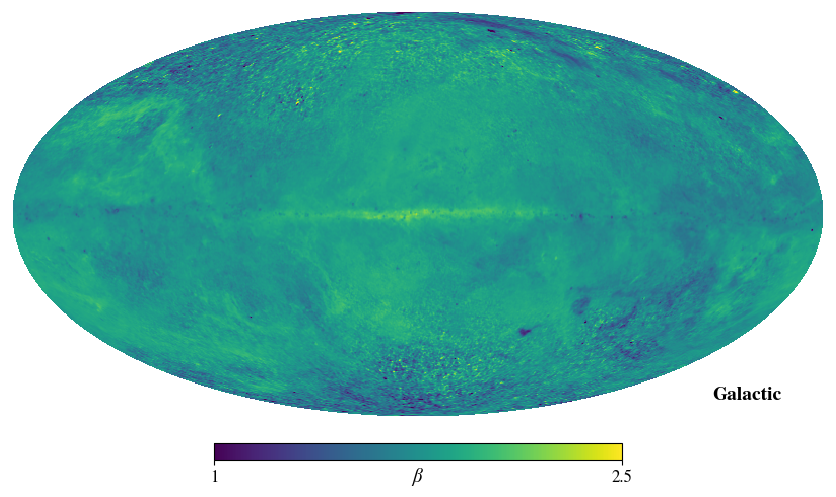

In [181]:
#====== For Plotting ======#
hp.mollview(beta_map, title='', coord=['G'], unit=r'$\beta$', nest=False, norm='log', cmap='viridis')
mpl.rcParams.update({'font.size':12})
plt.show()

In [182]:
d_from_LMC = np.sqrt((bighi_src_gl-LMC_center_gl)**2 + (bighi_src_gb-LMC_center_gb)**2)
d_from_SMC = np.sqrt((bighi_src_gl-SMC_center_gl)**2 + (bighi_src_gb-SMC_center_gb)**2)

id_far = np.where( (d_from_LMC > 6.) & (d_from_SMC > 4.))[0]
bighi_glon_far = bighi_src_gl[id_far]
bighi_glat_far = bighi_src_gb[id_far]

bighi_ts_mean_far = bighi_tspin_mean[id_far]
bighi_sigts_mean_far = bighi_sigtspin_mean[id_far]

big_tdust_far = big_tdust[id_far]
big_sigtdust_far = big_sigtdust[id_far]

big_beta_far = beta[id_far]
big_sigbeta_far = sigbeta[id_far]
print(big_beta_far.shape)

(214,)
214


In [183]:
big_tdust_far.shape

(214,)

In [184]:
d_from_LMC = np.sqrt((mc_src_gl-LMC_center_gl)**2 + (mc_src_gb-LMC_center_gb)**2)
d_from_SMC = np.sqrt((mc_src_gl-SMC_center_gl)**2 + (mc_src_gb-SMC_center_gb)**2)

id_far = np.where( (d_from_LMC > 6.) & (d_from_SMC > 4.))[0]
beta_far = beta[id_far]
sigbeta_far = sigbeta[id_far]
len(sigbeta_far)

290

In [187]:
vminmin = min(bighi_dens_ratio.min(), dens_ratio.min())
vminmin

nan

In [188]:
vmaxmax = max(bighi_dens_ratio.max(), dens_ratio.max())
vmaxmax

nan

In [189]:
vminmin = 0.04
vmaxmax = 0.22

# UV radiation strength

The strength of UV radiation in units of the Draine field using the expression derived for dust grains at
high Galactic latitudes (e.g., Boulanger et al. 1996; Paradis et al. 2011):

$I_{UV}$ = [$\frac{T_{dust}}{17.5 K}$]$^{\beta + 4}$

In [192]:
Iuv = tdust_map / 17.5
Iuv = Iuv**(beta_map+4)

### For components

In [197]:
theta = (90. - mc_src_gb_cpn)*deg2rad
phi   = mc_src_gl_cpn*deg2rad
pix   = hp.ang2pix(nside, theta, phi, nest=False)
Iuv_cpn    = Iuv[pix]
sigIuv_cpn = 0.1 * Iuv_cpn
print(len(Iuv_cpn))
Iuv_cpn[:5]

691


array([3.2095716, 5.1293745, 5.1293745, 1.9100888, 2.925418 ],
      dtype=float32)

In [198]:
d_from_LMC_cpn = np.sqrt((mc_src_gl_cpn-LMC_center_gl)**2 + (mc_src_gb_cpn-LMC_center_gb)**2)
d_from_SMC_cpn = np.sqrt((mc_src_gl_cpn-SMC_center_gl)**2 + (mc_src_gb_cpn-SMC_center_gb)**2)

id_cpn_far = np.where( (d_from_LMC_cpn > 6.) & (d_from_SMC_cpn > 4.))[0]
glon_cpn_far = mc_src_gl_cpn[id_cpn_far]
glat_cpn_far = mc_src_gb_cpn[id_cpn_far]

ts_cpn_far = ts[id_cpn_far]
sigts_cpn_far = sigts[id_cpn_far]

Iuv_cpn_far = Iuv_cpn[id_cpn_far]
sigIuv_cpn_far = sigIuv_cpn[id_cpn_far]
len(sigIuv_cpn_far)

443

### For Tsmean along linesights

In [201]:
theta = (90. - bighicat_gb)*deg2rad
phi   = bighicat_gl*deg2rad
pix   = hp.ang2pix(nside, theta, phi, nest=False)
bighicat_Iuv    = Iuv[pix]
bighicat_sigIuv = bighicat_Iuv*0.1
print(len(bighicat_Iuv))
bighicat_Iuv[:5]

199


array([1.9128758, 1.1054035, 1.1054035, 2.0252748, 2.3049507],
      dtype=float32)

In [202]:
theta = (90. - bighi_src_gb)*deg2rad
phi   = bighi_src_gl*deg2rad
pix   = hp.ang2pix(nside, theta, phi, nest=False)
big_Iuv    = Iuv[pix]
big_sigIuv = 0.1 * big_Iuv
print(len(big_Iuv))
big_Iuv[:5]

214


array([3.6152787, 1.1054035, 1.1054035, 2.0252748, 2.3049507],
      dtype=float32)

In [203]:
d_from_LMC = np.sqrt((bighi_src_gl-LMC_center_gl)**2 + (bighi_src_gb-LMC_center_gb)**2)
d_from_SMC = np.sqrt((bighi_src_gl-SMC_center_gl)**2 + (bighi_src_gb-SMC_center_gb)**2)

id_far = np.where( (d_from_LMC > 6.) & (d_from_SMC > 4.))[0]
bighi_glon_far = bighi_src_gl[id_far]
bighi_glat_far = bighi_src_gb[id_far]

bighi_ts_mean_far = bighi_tspin_mean[id_far]
bighi_sigts_mean_far = bighi_sigtspin_mean[id_far]

big_Iuv_far = big_Iuv[id_far]
big_sigIuv_far = big_sigIuv[id_far]
print(len(big_Iuv_far))

214


In [204]:
theta = (90. - mc_src_gb)*deg2rad
phi   = mc_src_gl*deg2rad
pix   = hp.ang2pix(nside, theta, phi, nest=False)
gaskap_Iuv    = Iuv[pix]
gaskap_sigIuv = 0.1 * gaskap_Iuv
print(len(gaskap_Iuv))
gaskap_Iuv[:5]

462


array([1.6476564, 2.1122499, 1.6454815, 1.679687 , 2.1669846],
      dtype=float32)

In [205]:
d_from_LMC = np.sqrt((mc_src_gl-LMC_center_gl)**2 + (mc_src_gb-LMC_center_gb)**2)
d_from_SMC = np.sqrt((mc_src_gl-SMC_center_gl)**2 + (mc_src_gb-SMC_center_gb)**2)

id_far = np.where( (d_from_LMC > 6.) & (d_from_SMC > 4.))[0]
glon_far = mc_src_gl_cpn[id_far]
glat_far = mc_src_gb_cpn[id_far]

ts_mean_far = tspin_mean[id_far]
sigts_mean_far = sigtspin_mean[id_far]

Iuv_far = gaskap_Iuv[id_far]
sigIuv_far = gaskap_sigIuv[id_far]
len(sigIuv_far)

290

In [206]:
aa = (gaskap_tdust_far/17.5)
bb = (beta_far+4.)
Iuv_far = aa**bb

sigaa = gaskap_sigtdust_far / 17.5
sigbb = sigbeta_far

tmp_fact = ((bb/aa)*sigaa)**2
tmp_fact += (np.log(aa)*sigbb)**2
sigIuv_far = np.sqrt(tmp_fact*Iuv_far**2)
sigIuv_far.shape

(290,)

In [210]:
def binned_avg(x: np.ndarray, y: np.ndarray, bin_edges: np.ndarray, n_resamples = 1000):
    from scipy import stats

    # Calculate the bin average using scipy
    bin_avg, _, _ = stats.binned_statistic(x, y, statistic='median', bins=bin_edges)

    # Container for bin averages
    bin_avg_arr = []

    # Perform bootstrap resampling and calculate bin averages
    for _ in range(n_resamples):
        resample_indices = np.random.choice(len(y), size=len(y), replace=True)
        resample_y= y[resample_indices]
        bin_avg_resample, _, _ = stats.binned_statistic(x, resample_y, statistic='median', bins=bin_edges)
        bin_avg_arr.append(bin_avg_resample)

    # Compute the upper and lower percentiles of the bin averages
    bin_avg_arr = np.array(bin_avg_arr)
    bin_mean_arr = np.mean(bin_avg_arr, axis=0)
    bin_avg_upper = np.percentile(bin_avg_arr, 97.5, axis=0) - bin_mean_arr + bin_avg
    bin_avg_lower = np.percentile(bin_avg_arr, 2.5, axis=0) - bin_mean_arr + bin_avg

    return bin_avg, bin_avg_upper, bin_avg_lower

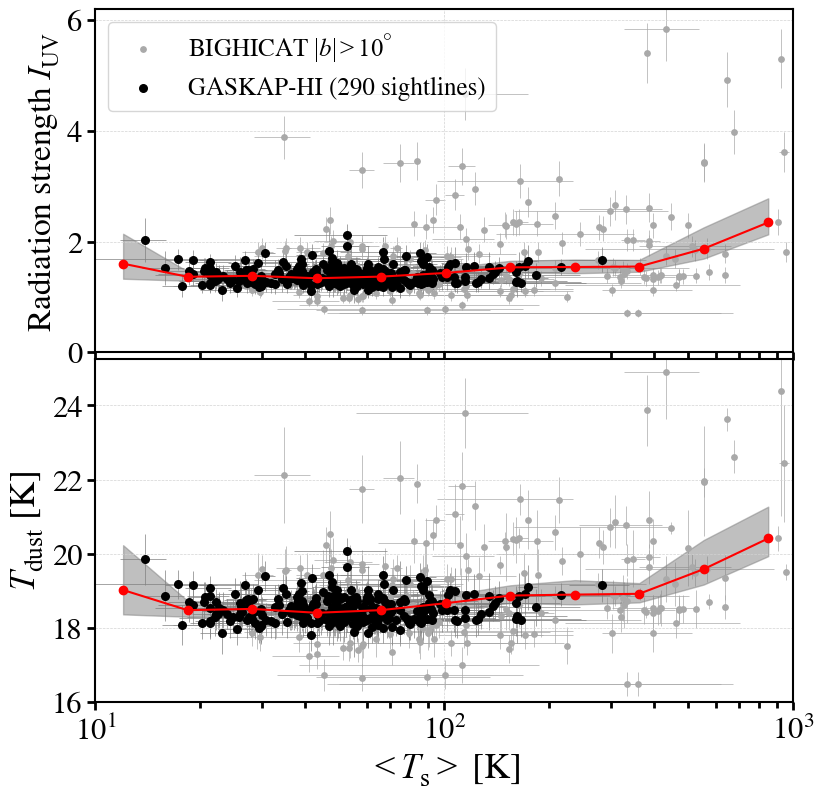

In [231]:
fig = plt.figure(figsize=(9,9))

# ax1
ax = fig.add_subplot(211)


ax.errorbar(bighi_ts_mean_far, big_Iuv_far,
             xerr=bighi_sigts_mean_far, yerr=big_sigIuv_far, zorder=1, 
             color='darkgrey', marker='d', ls='None', markersize=2,
             markeredgecolor='darkgrey', markeredgewidth=1,
             ecolor='darkgrey', elinewidth=0.5,
             label='')

sct1 = ax.scatter(bighi_ts_mean_far, big_Iuv_far,
                   zorder=2, s=15,
                   marker='o', c='darkgrey', vmin=0., vmax=37.,
                   label='BIGHICAT ' + r'$|b| > 10^{\circ}$')


ax.errorbar(ts_mean_far, Iuv_far,
             xerr=sigts_mean_far, yerr=sigIuv_far, zorder=1, 
             color='grey', marker='o', ls='None', markersize=2,
             markeredgecolor='grey', markeredgewidth=1,
             ecolor='grey', elinewidth=0.5,
             label='')

sct1 = ax.scatter(ts_mean_far, Iuv_far,
                   zorder=2, s=30,
                   marker='o', c='k', vmin=0., vmax=37.,
                   label='')



# Define the bin edges
low = 12.
high = 1300.
log_bin_edges = np.linspace(np.log10(low), np.log10(high), 12)
bin_edges = 10**log_bin_edges

bin_avg, bin_avg_upper, bin_avg_lower = binned_avg(np.concatenate((bighi_ts_mean_far, ts_mean_far)), np.concatenate((big_Iuv_far, Iuv_far)), bin_edges)

ax.plot(bin_edges[:-1], bin_avg,
                   zorder=3,
                   marker='o', c='r',
                   ls='-',
                   label='')
ax.fill_between(bin_edges[:-1], bin_avg_upper, bin_avg_lower, color='gray', alpha=0.5, label='')

ax.set_ylabel(r'Radiation strength $I_\mathrm{UV}$', fontsize=24) # [Draine unit]

ax.set_xlim(10., 1000.)
ax.set_ylim(0., 6.2)

ax.tick_params(axis='x', labelsize=0, pad=4)
ax.tick_params(axis='y', labelsize=22)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=6)
ax.tick_params(which='minor', length=4)

ax.set_xscale('log')

ax.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)
ax.legend(loc='upper left', fontsize=18)




# ax2
ax = fig.add_subplot(212,sharex=ax)




ax.errorbar(bighi_ts_mean_far, big_tdust_far,
             xerr=bighi_sigts_mean_far, yerr=big_sigtdust_far, zorder=1, 
             color='darkgrey', marker='d', ls='None', markersize=2,
             markeredgecolor='darkgrey', markeredgewidth=1,
             ecolor='darkgrey', elinewidth=0.5,
             label='')

sct1 = ax.scatter(bighi_ts_mean_far, big_tdust_far,
                   zorder=2, s=15,
                   marker='o', c='darkgrey',
                   label='BIGHICAT ' + r'$|b| > 10^{\circ}$')


ax.errorbar(ts_mean_far, gaskap_tdust_far,
             xerr=sigts_mean_far, yerr=gaskap_sigtdust_far, zorder=1, 
             color='grey', marker='o', ls='None', markersize=2,
             markeredgecolor='grey', markeredgewidth=1,
             ecolor='grey', elinewidth=0.5,
             label='')

sct1 = ax.scatter(ts_mean_far, gaskap_tdust_far,
                   zorder=2, s=30,
                   marker='o', c='k',
                   label=f'')

# Define the bin edges
low = 12.
high = 1300.
log_bin_edges = np.linspace(np.log10(low), np.log10(high), 12)
bin_edges = 10**log_bin_edges

bin_avg, bin_avg_upper, bin_avg_lower = binned_avg(np.concatenate((bighi_ts_mean_far, ts_mean_far)), np.concatenate((big_tdust_far, gaskap_tdust_far)), bin_edges)

ax.plot(bin_edges[:-1], bin_avg,
                   zorder=3,
                   marker='o', c='r',
                   ls='-',
                   label='')
ax.fill_between(bin_edges[:-1], bin_avg_upper, bin_avg_lower, color='gray', alpha=0.5, label='')


ax.set_ylabel(r'$T_\mathrm{dust}$ [K]', fontsize=26)
ax.set_xlabel(r'$<T_\mathrm{s}>$ [K]', fontsize=26, fontweight='normal')

ax.set_ylim(16, 25.25)
ax.set_xlim(10., 1000.)

ax.tick_params(axis='x', labelsize=22, pad=4)
ax.tick_params(axis='y', labelsize=22)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=6)
ax.tick_params(which='minor', length=4)

ax.set_xscale('log')
ax.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)



# set the spacing between subplots
plt.subplots_adjust(left=None,
                    bottom=None,
                    right=None,
                    top=None,
                    wspace=0.0,
                    hspace=0.02
                    )


plt.show()

In [215]:
bighi_ts_mean_far.shape

(214,)

In [217]:
gaskap_tdust_far.shape

(290,)

In [218]:
big_Iuv_far.shape

(214,)

In [219]:
bighi_ts_mean_far.shape

(214,)